### A look IMDb Biopics movies database

The idea for this notebook originate from the speech made by Cate Blanchett and Agnes Varda on the Cannes festival red carpet this year in May 2024. Their speech is a call for gender equality in the movie industry.

https://www.vox.com/culture/2018/5/13/17347738/cannes-womens-protest-march-film-festival-cate-blanchett-agnes-varda-timesup-red-carpet

It reminded me of another article, dealing as well with the lack of diversity in the movie industry. 

https://fivethirtyeight.com/features/straight-outta-compton-is-the-rare-biopic-not-about-white-dudes/

So I decided to use (and expand) the dataset available on Github for this last article and explore further the data:

https://github.com/fivethirtyeight/data/tree/master/biopics

### 1. Business Understanding

#### Objective
The primary goal of this analysis is to gain insights into biopic movies. It aims to answer the following questions:
1. What is the distribution of biopic movies over the years and the gender diversity in the biopics subjects?
2. Who are the most frequent actors playing in biopics and which type of subject do they play?
3. What are the most common attributes (sex, race, profession) of the biopic subjects?
4. Which biopic movies received the highest ratings and is there a correlation with its box office revenue?
5. Can we predict the rating of a biopic movie based on some of its features using machine learning?

#### Dataset Description
- `biopics.csv`: Contains information about various biopic movies.

It contains the following variables:

Variable | Definition
---|---------
`title` | Title of the film.
`site` | URL from IMDB.
`country` | Country of origin.
`year_released` | Year of release.
`box_office` | Gross earnings at U.S. box office.
`director` | Director of film.
`number_of_subjects` | The number of subjects featured in the film.
`subject` | The actual name of the featured subject.
`type_of_subject` | The occupation of subject or reason for recognition.
`race_known` | Indicates whether the subject’s race was discernible based on background of self, parent, or grandparent.
`subject_race` | Race of the subject.
`person_of_color` | Dummy variable that indicates person of color.
`subject_sex` | Sex of subject.
`lead_actor_actress` | The actor or actress who played the subject.


Source: [IMDb](http://www.imdb.com/).

### 2. Data Understanding

In [1]:
# Import the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import requests
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report

C:\Users\loreant\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Load the dataset
df = pd.read_csv('biopics.csv', encoding='iso-8859-1')

# Display the first few rows of the dataframe
df.head()

,title,site,country,year_release,box_office,director,number_of_subjects,subject,type_of_subject,race_known,subject_race,person_of_color,subject_sex,lead_actor_actress
0,10 Rillington Place,http://www.imdb.com/title/tt0066730/,UK,1971,-,Richard Fleischer,1,John Christie,Criminal,Unknown,NaN,0,Male,Richard Attenborough
1,12 Years a Slave,http://www.imdb.com/title/tt2024544/,US/UK,2013,$56.7M,Steve McQueen,1,Solomon Northup,Other,Known,African American,1,Male,Chiwetel Ejiofor
2,127 Hours,http://www.imdb.com/title/tt1542344/,US/UK,2010,$18.3M,Danny Boyle,1,Aron Ralston,Athlete,Unknown,NaN,0,Male,James Franco
3,1987,http://www.imdb.com/title/tt2833074/,Canada,2014,-,Ricardo Trogi,1,Ricardo Trogi,Other,Known,White,0,Male,Jean-Carl Boucher
4,20 Dates,http://www.imdb.com/title/tt0138987/,US,1998,$537K,Myles Berkowitz,1,Myles Berkowitz,Other,Unknown,NaN,0,Male,Myles Berkowitz


In [3]:
# Get basic information about the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 761 entries, 0 to 760
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   title               761 non-null    object
 1   site                761 non-null    object
 2   country             761 non-null    object
 3   year_release        761 non-null    int64 
 4   box_office          761 non-null    object
 5   director            761 non-null    object
 6   number_of_subjects  761 non-null    int64 
 7   subject             761 non-null    object
 8   type_of_subject     761 non-null    object
 9   race_known          761 non-null    object
 10  subject_race        564 non-null    object
 11  person_of_color     761 non-null    int64 
 12  subject_sex         761 non-null    object
 13  lead_actor_actress  754 non-null    object
dtypes: int64(3), object(11)
memory usage: 83.4+ KB


In [4]:
# Check the number of unique data per field
df.nunique()

title                 668
site                  672
country                 7
year_release           86
box_office            338
director              488
number_of_subjects      4
subject               699
type_of_subject        27
race_known              2
subject_race           17
person_of_color         2
subject_sex             2
lead_actor_actress    574
dtype: int64

In [5]:
# Function to print values with more than one occurrence
def print_repeated_values(df):
    for column in df.columns:
        value_counts = df[column].value_counts()
        repeated_values = value_counts[value_counts > 1]
        if not repeated_values.empty:
            print(f"Column '{column}' has the following repeated values:")
            print(repeated_values)
            print()

# Call the function and check the biopic dataframe
print_repeated_values(df)

Column 'title' has the following repeated values:
The Bang Bang Club                4
Jersey Boys                       4
Escape from Alcatraz              3
Lords of Dogtown                  3
Devotion                          3
                                 ..
The Best Intentions               2
Quo Vadis                         2
Vincent & Theo                    2
Backbeat                          2
The Barretts of Wimpole Street    2
Name: title, Length: 82, dtype: int64

Column 'site' has the following repeated values:
http://www.imdb.com/title/tt1173687/    4
http://www.imdb.com/title/tt1742044/    4
http://www.imdb.com/title/tt1042877/    3
http://www.imdb.com/title/tt0099762/    3
http://www.imdb.com/title/tt0079116/    3
                                       ..
http://www.imdb.com/title/tt0802948/    2
http://www.imdb.com/title/tt0097336/    2
http://www.imdb.com/title/tt0056048/    2
http://www.imdb.com/title/tt0104350/    2
http://www.imdb.com/title/tt0067658/    2
Name

<u>*Finding*</u>:  
Total of 761 records are available in the biopic database.  
It appears that some duplicates are present for movie titles and subjects, which will need a closer look at.  
Also in the fields 'box_office' and 'type_of_subject', top repeated values are missing or generic values, respectively '-' and 'Other'.  
This is expected to affect the performance and interpretability of machine learning models.

### 3. Data Preparation

In [6]:
# Check for duplicates in the title and site columns
duplicates = df[df.duplicated(subset=['title', 'site'], keep=False)]

In [7]:
duplicates.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167 entries, 9 to 751
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   title               167 non-null    object
 1   site                167 non-null    object
 2   country             167 non-null    object
 3   year_release        167 non-null    int64 
 4   box_office          167 non-null    object
 5   director            167 non-null    object
 6   number_of_subjects  167 non-null    int64 
 7   subject             167 non-null    object
 8   type_of_subject     167 non-null    object
 9   race_known          167 non-null    object
 10  subject_race        123 non-null    object
 11  person_of_color     167 non-null    int64 
 12  subject_sex         167 non-null    object
 13  lead_actor_actress  161 non-null    object
dtypes: int64(3), object(11)
memory usage: 19.6+ KB


In [8]:
# Check the number of unique data per field in the duplicates
duplicates.nunique()

title                  78
site                   78
country                 6
year_release           46
box_office             46
director               72
number_of_subjects      3
subject               163
type_of_subject        16
race_known              2
subject_race            8
person_of_color         2
subject_sex             2
lead_actor_actress    149
dtype: int64

In [9]:
# Check the number of duplicates per number_of_subjects value
duplicates['number_of_subjects'].value_counts()

2    138
3     21
4      8
Name: number_of_subjects, dtype: int64

In [10]:
# Double check the sum of above counts equal to the total amount of duplicates
duplicates['number_of_subjects'].value_counts().sum()

167

<u>*Finding*</u>:  
Duplicates are found for movies title with identical link to IMDb website.  
These duplicates are only found for movies with more than one subject, as each row of the dataset contains the data for one subject only.

<u>*Action*</u>:  
When investigating the database with question related to the movies feature itself (in case of this notebook, it applies for questions 1. and 4.), this point will need to be handled carefully. 

In [11]:
# Check for duplicates in the title and subject columns
duplicates_1 = df[df.duplicated(subset=['title', 'subject'], keep=False)]

In [12]:
duplicates_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8 entries, 135 to 362
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   title               8 non-null      object
 1   site                8 non-null      object
 2   country             8 non-null      object
 3   year_release        8 non-null      int64 
 4   box_office          8 non-null      object
 5   director            8 non-null      object
 6   number_of_subjects  8 non-null      int64 
 7   subject             8 non-null      object
 8   type_of_subject     8 non-null      object
 9   race_known          8 non-null      object
 10  subject_race        7 non-null      object
 11  person_of_color     8 non-null      int64 
 12  subject_sex         8 non-null      object
 13  lead_actor_actress  8 non-null      object
dtypes: int64(3), object(11)
memory usage: 960.0+ bytes


In [13]:
duplicates_1

,title,site,country,year_release,box_office,director,number_of_subjects,subject,type_of_subject,race_known,subject_race,person_of_color,subject_sex,lead_actor_actress
135,Cleopatra,http://www.imdb.com/title/tt0024991/,US,1934,-,Cecil B. DeMille,1,Cleopatra,Historical,Known,Middle Eastern,1,Female,Claudette Colbert
136,Cleopatra,http://www.imdb.com/title/tt0056937/,US/UK,1963,$57.8M,Joseph L. Mankiewicz,1,Cleopatra,Historical,Known,Middle Eastern,1,Female,Elizabeth Taylor
172,Dillinger,http://www.imdb.com/title/tt0037644/,US,1945,$4M,Max Nosseck,1,John Dillinger,Criminal,Known,White,0,Male,Lawrence Tierney
173,Dillinger,http://www.imdb.com/title/tt0069976/,US,1973,-,John Milius,1,John Dillinger,Criminal,Unknown,NaN,0,Male,Warren Oates
250,Henry V,http://www.imdb.com/title/tt0036910/,UK,1944,-,Laurence Olivier,1,Henry V of England,Historical,Known,White,0,Male,Laurence Olivier
251,Henry V,http://www.imdb.com/title/tt0097499/,UK,1989,$10.2M,Kenneth Branagh,1,Henry V of England,Historical,Known,White,0,Male,Kenneth Branagh
361,Marie Antoinette,http://www.imdb.com/title/tt0030418/,US,1938,-,W.S. Van Dyke,1,Marie Antoinette,Historical,Known,White,0,Female,Norma Shearer
362,Marie Antoinette,http://www.imdb.com/title/tt0422720/,US,2006,$16M,Sofia Coppola,1,Marie Antoinette,Historical,Known,White,0,Female,Kirsten Dunst


<u>*Finding*</u>: 
Duplicates are also found for movies title with identical subject.  
These movies are different movies, 4 subjects (Cleopatra, John Dillinger, Henri V and Marie Antoinette) had been the subject of different biopics twice.

<u>*Action*</u>:
No action required with respect to the questions investigated in this notebook. 

In [14]:
# Check for duplicates in the site and subject columns
duplicates_2 = df[df.duplicated(subset=['site','subject'], keep=False)]

In [15]:
duplicates_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   title               0 non-null      object
 1   site                0 non-null      object
 2   country             0 non-null      object
 3   year_release        0 non-null      int64 
 4   box_office          0 non-null      object
 5   director            0 non-null      object
 6   number_of_subjects  0 non-null      int64 
 7   subject             0 non-null      object
 8   type_of_subject     0 non-null      object
 9   race_known          0 non-null      object
 10  subject_race        0 non-null      object
 11  person_of_color     0 non-null      int64 
 12  subject_sex         0 non-null      object
 13  lead_actor_actress  0 non-null      object
dtypes: int64(3), object(11)
memory usage: 0.0+ bytes


<u>*Finding*</u>: 
There is no record in the database of movie site duplicates with same subject.

<u>*Action*</u>:
No further action, all duplicates have been identified and no duplicate need to be removed from the original database.

In [16]:
# # Scrap the movies ratings from IMDb website
# # The full cell is commented to reduce the notebook running time

# def get_imdb_rating(url):
#     try:
#         headers = {
#             "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3"}
#         response = requests.get(url, headers=headers)
#         if response.status_code == 200:
#             soup = BeautifulSoup(response.text, 'html.parser')
#             # IMDb rating is found within a 'span' tag with a specific class
#             rating_tag = soup.find('span', class_='sc-bde20123-1 cMEQkK')
#             if rating_tag:
#                 return float(rating_tag.text.strip())
#             else:
#                 return None
#         else:
#             return None
#     except Exception as e:
#         print(f"Error fetching rating from {url}: {e}")
#         return None   
    
# # Create a new column for the ratings
# df['rating'] = df['site'].apply(get_imdb_rating)

# # Create new Excel file to import database in below cell
# df.to_excel("biopics_with_ratings.xlsx", index=False)

In [17]:
# Load the dataframe with IMDb ratings from Excel file created in above cell
df = pd.read_excel("biopics_with_ratings.xlsx")

In [18]:
# Create a new column 'decade' from the 'release_year' column
df['decade'] = df['year_release'].apply(lambda x: f"{(x // 10) * 10} - {(x // 10) * 10 + 9}")

In [19]:
# Create a new column 'rating_range' from the rating column
df['rating_range'] = df['rating'].apply(lambda x: f"{x // 1} - {x // 1 + 1}")

In [20]:
# Function to clean and convert 'box_office' data to float
def clean_revenue(revenue_str):
    if isinstance(revenue_str, str):
        # Use regex to find the numerical part and the scale
        match = re.match(r'\$?([\d,.]+)([MBK]?)', revenue_str.replace(',', ''))
        if match:
            number = float(match.group(1))
            scale = match.group(2)
            if scale == 'M':
                return number * 1e6
            elif scale == 'B':
                return number * 1e9
            elif scale == 'K':
                return number * 1e3
            else:
                return number
    return None

# Apply the function to clean and convert box_office
df['box_office'] = df['box_office'].apply(clean_revenue)

In [21]:
# Check the first rows of the data frame
df.head(5)

,title,site,country,year_release,box_office,director,number_of_subjects,subject,type_of_subject,race_known,subject_race,person_of_color,subject_sex,lead_actor_actress,rating,decade,rating_range
0,10 Rillington Place,http://www.imdb.com/title/tt0066730/,UK,1971,NaN,Richard Fleischer,1,John Christie,Criminal,Unknown,NaN,0,Male,Richard Attenborough,7.5,1970 - 1979,7.0 - 8.0
1,12 Years a Slave,http://www.imdb.com/title/tt2024544/,US/UK,2013,56700000.0,Steve McQueen,1,Solomon Northup,Other,Known,African American,1,Male,Chiwetel Ejiofor,8.1,2010 - 2019,8.0 - 9.0
2,127 Hours,http://www.imdb.com/title/tt1542344/,US/UK,2010,18300000.0,Danny Boyle,1,Aron Ralston,Athlete,Unknown,NaN,0,Male,James Franco,7.5,2010 - 2019,7.0 - 8.0
3,1987,http://www.imdb.com/title/tt2833074/,Canada,2014,NaN,Ricardo Trogi,1,Ricardo Trogi,Other,Known,White,0,Male,Jean-Carl Boucher,7.4,2010 - 2019,7.0 - 8.0
4,20 Dates,http://www.imdb.com/title/tt0138987/,US,1998,537000.0,Myles Berkowitz,1,Myles Berkowitz,Other,Unknown,NaN,0,Male,Myles Berkowitz,5.6,1990 - 1999,5.0 - 6.0


In [22]:
# Apply pd.get_dummies to 'decade' and 'subject_sex' but keep the original columns
decade_dummies = pd.get_dummies(df['decade'], prefix= 'decade', drop_first=True)
sex_dummies = pd.get_dummies(df['subject_sex'], prefix= 'sex', drop_first=True)
rating_dummies = pd.get_dummies(df['rating_range'], prefix= 'rating', drop_first=True)

# Concatenate the original DataFrame with the dummy variables
df_with_dummies = pd.concat([df, decade_dummies, sex_dummies, rating_dummies], axis=1)

### 4. Analysis

#### 1. What is the distribution of biopic movies over the years and the gender diversity in the biopics subjects?

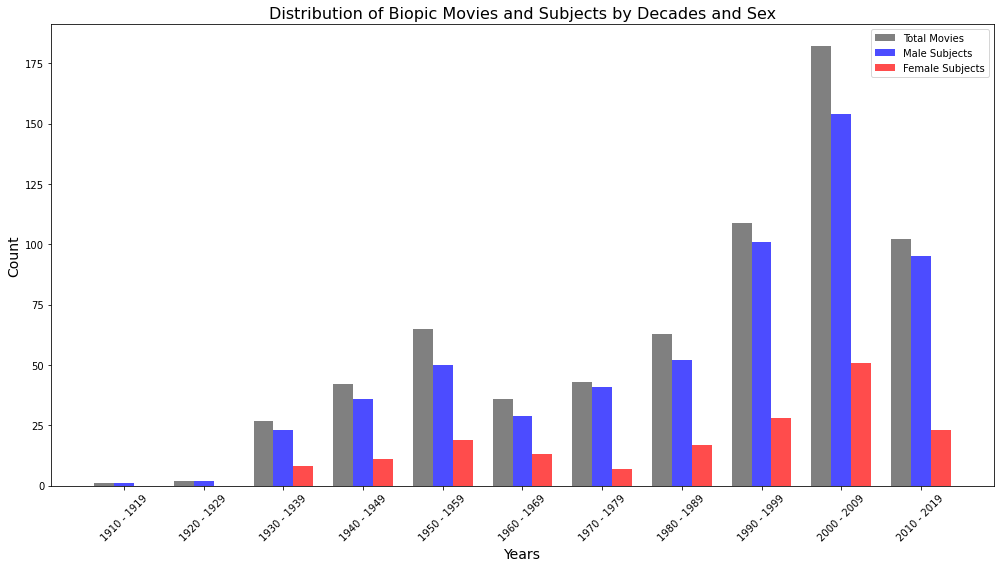

In [23]:
# Calculate the total number of movies per decade (each movie counted once)
movies_per_decade = df.drop_duplicates(subset=['site']).groupby('decade').size()

# Calculate the total number of subjects per decade and subject sex
subjects_per_decade_sex = df.groupby(['decade', 'subject_sex']).size().unstack().fillna(0)

# Create a DataFrame for plotting
plot_df = pd.DataFrame({
    'Total Movies': movies_per_decade,
    'Male Subjects': subjects_per_decade_sex['Male'],
    'Female Subjects': subjects_per_decade_sex['Female']
}).fillna(0)

# Plot the data
fig, ax = plt.subplots(figsize=(14, 8))

# Define bar width
bar_width = 0.25

# Positions of the bars on the x-axis
index = np.arange(len(plot_df))

# Plot total movies per decade
bar1 = ax.bar(index, plot_df['Total Movies'], bar_width, label='Total Movies', color='gray')

# Plot number of subjects by sex
bar2 = ax.bar(index + bar_width, plot_df['Male Subjects'], bar_width, label='Male Subjects', color='blue', alpha=0.7)
bar3 = ax.bar(index + 2 * bar_width, plot_df['Female Subjects'], bar_width, label='Female Subjects', color='red', alpha=0.7)

# Add labels and title
ax.set_xlabel('Years', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.set_title('Distribution of Biopic Movies and Subjects by Decades and Sex', fontsize=16)
ax.set_xticks(index + bar_width)
ax.set_xticklabels(plot_df.index, rotation=45)

# Combine legends
ax.legend()

plt.tight_layout()
plt.show()

<u>*Finding*</u>: 
There is an increase of biopics movies released since 1990, but through the last century there is a clear and constant trend that biopics are mostly made about male subjects. 

#### 2. Who are the most frequent actors playing in biopics and which type of subject do they play?

In [24]:
# Find the top 10 most frequent actors in biopics
actors = df['lead_actor_actress'].value_counts().head(10)
print("Most frequent actors in biopics:")
print(actors)

Most frequent actors in biopics:
Leonardo DiCaprio    7
Denzel Washington    6
Paul Newman          5
Anthony Hopkins      5
Johnny Depp          5
Ed Harris            4
Gary Cooper          4
Meryl Streep         4
Hilary Swank         4
Liam Neeson          4
Name: lead_actor_actress, dtype: int64


In [25]:
# List all the types of subjects each top actor has played
actor_subjects = df.groupby('lead_actor_actress')['type_of_subject'].apply(lambda x: x.unique()).loc[actors.index]

# Print the types of subjects played by each of these actors
print("Types of subjects played by these actors:")
for actor, subjects in actor_subjects.items():
    print(f"{actor}: {', '.join(subjects)}")

Types of subjects played by these actors:
Leonardo DiCaprio: Criminal, Government, Other, Author, Author (poet)
Denzel Washington: Criminal, Activist, Athlete, Academic
Paul Newman: Politician, Criminal, Military, Athlete
Anthony Hopkins: Author, Other, World leader, Athlete
Johnny Depp: Criminal, Government, Other, Author
Ed Harris: Musician, Artist, Athlete, Other
Gary Cooper: Military, Historical, Athlete
Meryl Streep: Other, Activist, World leader
Hilary Swank: Other
Liam Neeson: Academic, Activist, Other


<u>*Finding*</u>: 
As one could expect, the majority of biopics subjects being male subjects, the most frequent actors playing in biopics are also male actors. Regarding the type of occupation (or reason for recognition) of the subjects, there is no clear trend as each actor played a variety of subject types.  

#### 3. What are the most common attributes (sex, race, profession) of the biopic subjects?

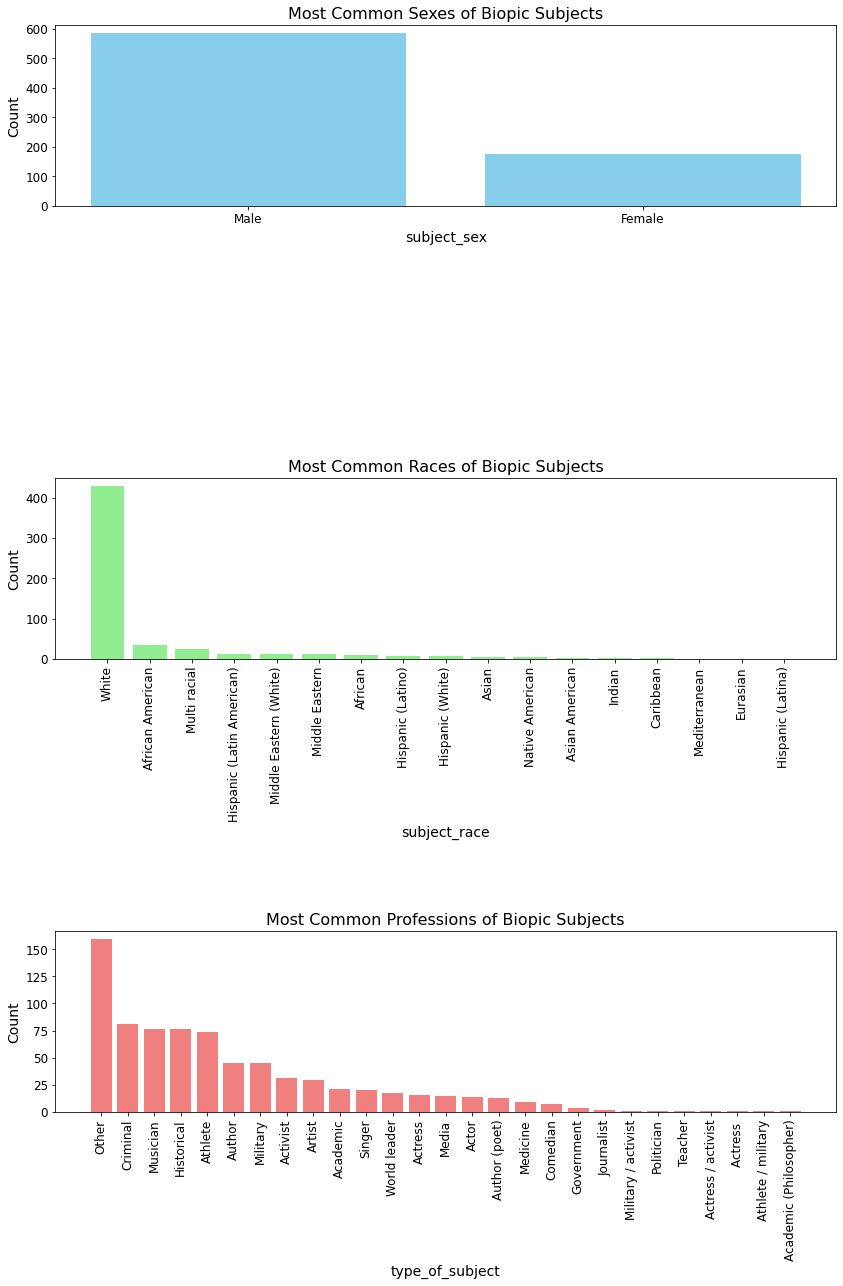

In [26]:
# Calculate the most common attributes
common_sex = df['subject_sex'].value_counts()
common_race = df['subject_race'].value_counts()
common_profession = df['type_of_subject'].value_counts()

# Plot the most common attributes
fig, axs = plt.subplots(3, 1, figsize=(14, 20))

# Increase the vertical gaps between subplots
fig.subplots_adjust(hspace=1.5)

# Plot for sex
axs[0].bar(common_sex.index, common_sex.values, color='skyblue')
axs[0].set_title('Most Common Sexes of Biopic Subjects', fontsize=16)
axs[0].set_xlabel('subject_sex', fontsize=14)
axs[0].set_ylabel('Count', fontsize=14)
axs[0].tick_params(axis='x', labelsize=12)
axs[0].tick_params(axis='y', labelsize=12)

# Plot for race
axs[1].bar(common_race.index, common_race.values, color='lightgreen')
axs[1].set_title('Most Common Races of Biopic Subjects', fontsize=16)
axs[1].set_xlabel('subject_race', fontsize=14)
axs[1].set_ylabel('Count', fontsize=14)
axs[1].tick_params(axis='x', labelsize=12, rotation=90)
axs[1].tick_params(axis='y', labelsize=12)

# Plot for profession
axs[2].bar(common_profession.index, common_profession.values, color='lightcoral')
axs[2].set_title('Most Common Professions of Biopic Subjects', fontsize=16)
axs[2].set_xlabel('type_of_subject', fontsize=14)
axs[2].set_ylabel('Count', fontsize=14)
axs[2].tick_params(axis='x', labelsize=12, rotation=90)
axs[2].tick_params(axis='y', labelsize=12)

plt.show()

<u>*Finding*</u>: 
White (and male) subjects are the main subjects of biopics.  
In terms of profession (or reason for recognition) there is a wide range represented in biopics. 

#### 4. Which biopic movies received the highest ratings and is there a correlation with its box office revenue?

In [27]:
# Find the top 30 best rated biopics
top_rated_biopics = df.drop_duplicates(subset=['site'])[['title', 'rating', 'box_office']].sort_values(by='box_office', ascending=False).head(30)
print("Top rated biopic movies:")
print(top_rated_biopics)

Top rated biopic movies:
                                  title  rating   box_office
38                      American Sniper     7.3  350000000.0
545                      The Blind Side     7.6  256000000.0
332                             Lincoln     7.3  182000000.0
11                     A Beautiful Mind     8.2  171000000.0
122                 Catch Me If You Can     8.1  164000000.0
669                  The Sound of Music     8.1  163000000.0
653            The Pursuit of Happyness     8.0  163000000.0
605                   The King's Speech     8.0  139000000.0
422                         Patch Adams     6.8  135000000.0
36                    American Gangster     7.8  130000000.0
189                     Erin Brockovich     7.4  126000000.0
336                       Lone Survivor     7.5  125000000.0
230               Good Morning, Vietnam     7.3  124000000.0
732                       Walk the Line     7.8  120000000.0
690             The Wolf of Wall Street     8.2  117000000.0

In [28]:
# Check correlation between rating and box office revenue
# Create new dataframe without movies duplicate
df_correlation = df.drop_duplicates(subset=['site'])[['rating', 'box_office']]

# Drop records without box office revenue data
df_correlation = df_correlation.dropna()

correlation = df_correlation.corr().iloc[0, 1]
print(f"Correlation between rating and box office revenue: {correlation}")

Correlation between rating and box office revenue: 0.3715619892313854


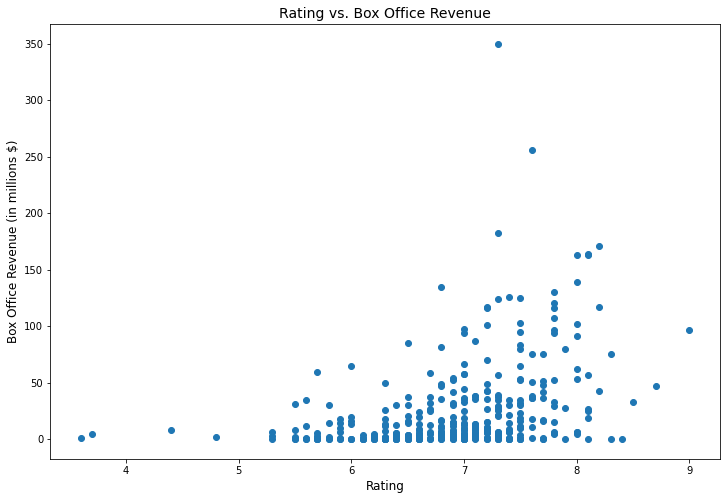

In [29]:
# Create a scatterplot with Matplotlib
plt.figure(figsize=(12, 8))
plt.scatter(df_correlation['rating'], df_correlation['box_office'] / 1e6)

# Add labels and title
plt.title('Rating vs. Box Office Revenue', fontsize=14)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Box Office Revenue (in millions $)', fontsize=12)

plt.show()

In [30]:
# Extract rating range from the rating column
df_correlation['rating_range'] = df_correlation['rating'].apply(lambda x: f"{x // 1} - {x // 1 + 1}")

In [31]:
revenue_per_rating = df_correlation.groupby('rating_range')['box_office'].mean()
print(f"Average box office revenue per IMDb rating range:\n{revenue_per_rating}")

Average box office revenue per IMDb rating range:
rating_range
3.0 - 4.0     2.795000e+06
4.0 - 5.0     5.125000e+06
5.0 - 6.0     8.166737e+06
6.0 - 7.0     1.095223e+07
7.0 - 8.0     3.158712e+07
8.0 - 9.0     6.527847e+07
9.0 - 10.0    9.610000e+07
Name: box_office, dtype: float64


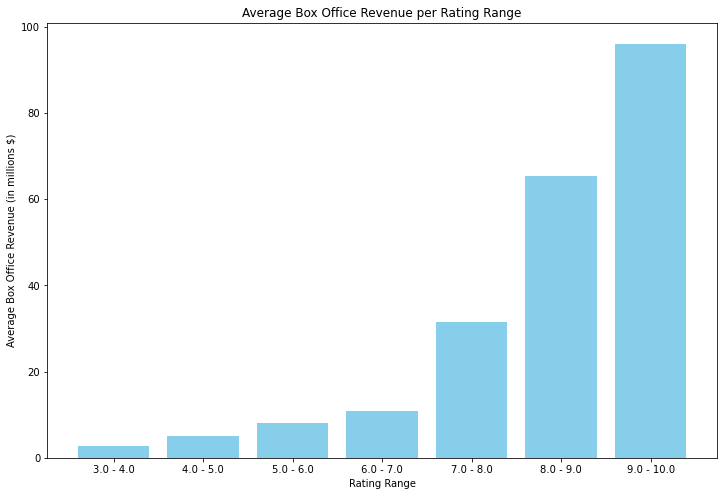

In [32]:
# Plot the data
plt.figure(figsize=(12, 8))
plt.bar(revenue_per_rating.index, revenue_per_rating.values / 1e6, color='skyblue')

# Add labels and title
plt.title('Average Box Office Revenue per Rating Range')
plt.xlabel('Rating Range')
plt.ylabel('Average Box Office Revenue (in millions $)')

plt.show()

<u>*Finding*</u>: 
When comparing the movies revenues to their IMDb rating "one by one", there is no strong correlation although at trend can be observed that there is higher chance for a high rating movie to be successful in the box office.  
This trend is further confirmed when looking at average box office revenues per rating range.

### 5. Modeling

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

df_with_dummies = df_with_dummies.dropna()

# Define features and target variable for prediction
features = df_with_dummies.drop(columns=['title', 'site', 'country', 'year_release',
       'director', 'subject', 'type_of_subject', 'decade',
       'race_known', 'subject_race', 'subject_sex',
       'lead_actor_actress', 'rating', 'rating_range', 'rating_3.0 - 4.0',
       'rating_4.0 - 5.0', 'rating_5.0 - 6.0', 'rating_6.0 - 7.0',
       'rating_7.0 - 8.0', 'rating_8.0 - 9.0', 'rating_9.0 - 10.0'], axis=1)

#features = df_dum.drop(['title', 'rating'], axis=1)
target = df_with_dummies['rating']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

#### 5. Can we predict the rating of a biopic movie based on its features using machine learning?

In [34]:
print("Model Evaluation Metrics:")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Model Evaluation Metrics:
Mean Squared Error: 0.29172028364952385
R-squared: 0.12005487710639906


In [35]:
# Define features and target variable for prediction
features = df_with_dummies.drop(columns=['title', 'site', 'country', 'year_release',
       'director', 'subject', 'type_of_subject', 'decade',
       'race_known', 'subject_race', 'subject_sex',
       'lead_actor_actress', 'rating', 'rating_range', 'rating_3.0 - 4.0',
       'rating_4.0 - 5.0', 'rating_5.0 - 6.0', 'rating_6.0 - 7.0',
       'rating_7.0 - 8.0', 'rating_8.0 - 9.0', 'rating_9.0 - 10.0'], axis=1)

#features = df_dum.drop(['title', 'rating'], axis=1)
target = df_with_dummies[['rating_3.0 - 4.0',
       'rating_4.0 - 5.0', 'rating_5.0 - 6.0', 'rating_6.0 - 7.0',
       'rating_7.0 - 8.0', 'rating_8.0 - 9.0', 'rating_9.0 - 10.0']]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Train random forest classifier
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(classification_report(y_test, y_pred))

Accuracy: 0.53
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         4
           3       0.67      0.64      0.65        28
           4       0.60      0.52      0.56        29
           5       0.20      0.33      0.25         3
           6       0.00      0.00      0.00         0

   micro avg       0.57      0.53      0.55        64
   macro avg       0.21      0.21      0.21        64
weighted avg       0.57      0.53      0.55        64
 samples avg       0.53      0.53      0.53        64



C:\Users\loreant\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\loreant\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\loreant\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<u>*Finding*</u>: 
Prediction of linear regression and random forest classifier is not good when using the available dataset.